# Analyzing Aftershock Sequences in Bogo City, Cebu using Unsupervised and Supervised Learning
Authors: Charrie Anne Nacor and Joanna Marie Pagtalunan

## 1. Introduction and Problem Statement
The Bogo Bay Fault, a previously undermapped fault just offshore northern Cebu, ruptured during a 6.9 magnitude earthquake on September 30, 2025, near Bogo City. Since the earthquake, the region has continued to experience a sequence of aftershocks. 

This notebook implements a two-step approach to analyze this aftershock sequence.

1. **Unsupervised Learning.** Identify natural groupings in the aftershock data based on location, depth, magnitude, and timing
2. **Supervised Learning.** Train classifiers to evaluate whether the identified clusters identified by the unsupervised algorithm are meaningful and well-separated

We will compare

* **Clustering Methods.** K-Means vs K-Medoids
* **Classification Methods.** Support Vector Classifier (SVC) vs XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids  
from sklearn.manifold import TSNE 
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
import time

# Set visualization style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported successfully! \n")

print("PROJECT: Analyzing Aftershock Patterns in Bogo City, Cebu")
print("MAINSHOCK: 6.9 magnitude on September 30, 2025")
print("ANALYSIS PERIOD: 30-day aftershock sequence (October 1-30, 2025)")
print("METHODOLOGY: Two-step approach (Unsupervised to Supervised Learning)")

Libraries imported successfully! 

PROJECT: Analyzing Aftershock Patterns in Bogo City, Cebu
MAINSHOCK: 6.9 magnitude on September 30, 2025
ANALYSIS PERIOD: 30-day aftershock sequence (October 1-30, 2025)
METHODOLOGY: Two-step approach (Unsupervised to Supervised Learning)


## 2. Data Loading and Preprocessing

We will use the Philippine Earthquakes dataset from PHIVOLCS (Public Domain License) which contains records from 2016 to November 15, 2025. Each entry includes date/time, geographical coordinates, depth, magnitude, and nearest location.

For this analysis, we have extracted all earthquakes from October 1-30, 2025 in Bogo City, Cebu.

In [2]:
class EarthquakeAnalysis:
    def __init__(self, filename):
        self.df = self.load_and_preprocess_data(filename)
        self.features = ['Latitude', 'Longitude', 'Depth_In_Km', 'Magnitude', 'hours_since_start']
        self.X = self.df[self.features].values
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        
    def load_and_preprocess_data(self, filename):
        # Load the dataset
        df = pd.read_csv(filename)

        # Convert datetime to pandas datetime object
        df['datetime'] = pd.to_datetime(df['Date_Time_PH'])
        
        # Filter data for October 1 to October 30, 2025
        start_date = pd.to_datetime('2025-10-01')
        end_date = pd.to_datetime('2025-10-30 23:59:00')
        df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]
        
        # Extract date and time components
        df['date'] = df['datetime'].dt.date
        df['time'] = df['datetime'].dt.time

        # Calculate hours since the first earthquake 
        start_time = df['datetime'].min()
        df['hours_since_start'] = (df['datetime'] - start_time).dt.total_seconds() / 3600

        return df

filename = 'phivolcs_oct01_oct30_bogo_2025.csv'
analysis = EarthquakeAnalysis(filename)

print(f"Dataset loaded successfully with {len(analysis.df)} records.")
print("\nFirst 5 rows of the preprocessed dataset.")
display(analysis.df.tail().iloc[::-1])

Dataset loaded successfully with 3050 records.

First 5 rows of the preprocessed dataset.


,Date_Time_PH,Latitude,Longitude,Depth_In_Km,Magnitude,Location,Specific_Location,General_Location,datetime,date,time,hours_since_start
3090,2025-10-01 00:01:00,10.83,123.95,10.0,4.5,024 km S 08° W of City Of Bogo (Cebu),City Of Bogo,Cebu,2025-10-01 00:01:00,2025-10-01,00:01:00,0.000000
3089,2025-10-01 00:04:00,11.05,123.97,8.0,3.6,001 km N 49° W of City Of Bogo (Cebu),City Of Bogo,Cebu,2025-10-01 00:04:00,2025-10-01,00:04:00,0.050000
3088,2025-10-01 00:06:00,10.95,123.89,2.0,2.0,014 km S 42° W of City Of Bogo (Cebu),City Of Bogo,Cebu,2025-10-01 00:06:00,2025-10-01,00:06:00,0.083333
3087,2025-10-01 00:12:00,11.08,124.11,6.0,2.5,015 km N 77° E of City Of Bogo (Cebu),City Of Bogo,Cebu,2025-10-01 00:12:00,2025-10-01,00:12:00,0.183333
3086,2025-10-01 00:15:00,11.19,124.11,3.0,2.4,022 km N 41° E of City Of Bogo (Cebu),City Of Bogo,Cebu,2025-10-01 00:15:00,2025-10-01,00:15:00,0.233333


## 3. Exploratory Data Analysis

We explore the basic characteristics of our earthquake dataset to understand its properties.

In [3]:
def exploratory_analysis(self):
    print(f"Time Range: {self.df['datetime'].min()} to {self.df['datetime'].max()}")
    print(f"Total Earthquakes: {len(self.df)}")
    print(f"Magnitude Range: {self.df['Magnitude'].min()} to {self.df['Magnitude'].max()}")
    print(f"Depth Range: {self.df['Depth_In_Km'].min()} to {self.df['Depth_In_Km'].max()} km")
    
    # Display basic statistics
    print("\nBasic Statistics:")
    display(self.df[['Magnitude', 'Depth_In_Km', 'Latitude', 'Longitude']].describe())

EarthquakeAnalysis.exploratory_analysis = exploratory_analysis
analysis.exploratory_analysis()

Time Range: 2025-10-01 00:01:00 to 2025-10-30 23:04:00
Total Earthquakes: 3050
Magnitude Range: 1.0 to 5.8
Depth Range: 1.0 to 60.0 km

Basic Statistics:


,Magnitude,Depth_In_Km,Latitude,Longitude
count,3050.000000,3050.000000,3050.000000,3050.000000
mean,2.215475,15.410820,11.065449,124.016974
std,0.616109,11.819683,0.104524,0.093453
min,1.000000,1.000000,10.630000,123.190000
25%,1.800000,5.000000,10.990000,123.950000
50%,2.100000,11.000000,11.080000,124.010000
75%,2.500000,27.000000,11.140000,124.080000
max,5.800000,60.000000,11.620000,124.300000


## 4. Clustering Tendency Assessment (Hopkins Statistic)

The Hopkins statistic assesses the clustering tendency of the data:

* **H > 0.5.** Significant clustering tendency
* **H ≈ 0.5.** Uniformly distributed
* **H < 0.5.** Regularly spaced

This helps confirm whether our aftershock data has meaningful patterns for clustering.

Calculating Hopkins statistic with sample size: 100
Data dimensions: 3050 samples, 5 features


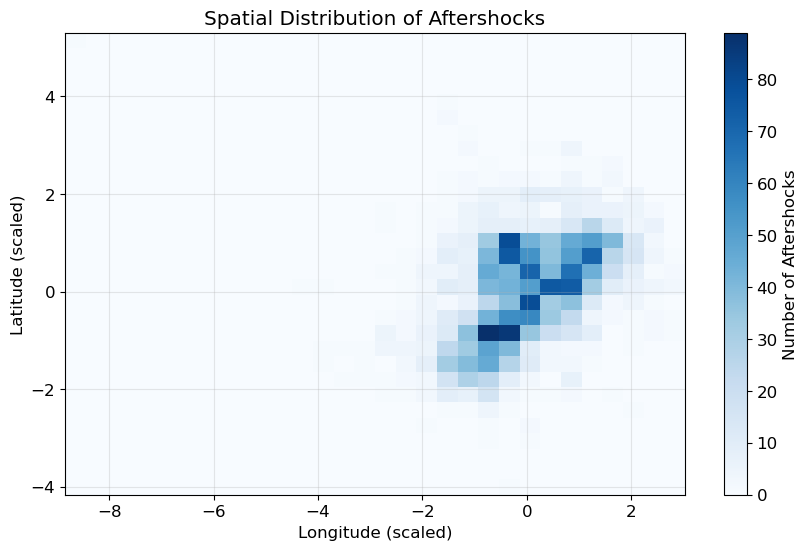

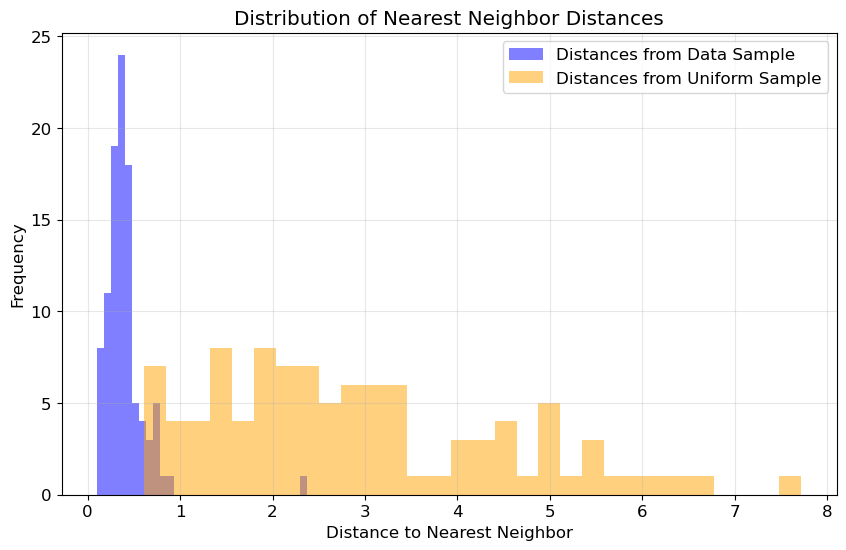

Hopkins Statistic: 0.9994
The data has a significant tendency to cluster (H > 0.5).
This suggests the aftershocks have distinct patterns worth exploring.


In [4]:
def hopkins_statistic(self, sample_size=None):
    if sample_size is None:
        sample_size = min(int(0.1 * self.X_scaled.shape[0]), 100)
    
    n = self.X_scaled.shape[0]
    d = self.X_scaled.shape[1]

    print(f"Calculating Hopkins statistic with sample size: {sample_size}")
    print(f"Data dimensions: {n} samples, {d} features")

    # For reproducibility
    np.random.seed(96)
    
    # Generate a uniform random sample
    uniform_sample = np.random.uniform(np.min(self.X_scaled, axis=0), np.max(self.X_scaled, axis=0), (sample_size, d))
    
    # Generate a random sample from the data
    random_indices = np.random.choice(n, sample_size, replace=False)
    data_sample = self.X_scaled[random_indices]
    
    # Calculate distances to nearest neighbors in the data
    nbrs = NearestNeighbors(n_neighbors=2).fit(self.X_scaled)
    distances, indices = nbrs.kneighbors(data_sample)
    u_distances = distances[:, 1]
    
    # Calculate distances from uniform sample to nearest neighbors in the data
    distances, indices = nbrs.kneighbors(uniform_sample)
    w_distances = distances[:, 0]
    
    # Calculate Hopkins statistic
    u_sum = np.sum(u_distances**d)
    w_sum = np.sum(w_distances**d)
    
    hopkins = w_sum / (u_sum + w_sum)

    # Plot the spatial histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(self.X_scaled[:, 1], self.X_scaled[:, 0], bins=30, cmap='Blues')
    plt.colorbar(label='Number of Aftershocks')
    plt.xlabel('Longitude (scaled)')
    plt.ylabel('Latitude (scaled)')
    plt.title('Spatial Distribution of Aftershocks')
    plt.show()

    # Plot the distribution of distances
    plt.figure(figsize=(10, 6))
    plt.hist(u_distances, bins=30, alpha=0.5, label='Distances from Data Sample', color='blue')
    plt.hist(w_distances, bins=30, alpha=0.5, label='Distances from Uniform Sample', color='orange')
    plt.xlabel('Distance to Nearest Neighbor')
    plt.ylabel('Frequency')
    plt.title('Distribution of Nearest Neighbor Distances')
    plt.legend()
    plt.show()
    
    return hopkins

EarthquakeAnalysis.hopkins_statistic = hopkins_statistic

# Calculate Hopkins statistic
hopkins = analysis.hopkins_statistic()
print(f"Hopkins Statistic: {hopkins:.4f}")

if hopkins > 0.5:
    print("The data has a significant tendency to cluster (H > 0.5).")
    print("This suggests the aftershocks have distinct patterns worth exploring.")
elif hopkins > 0.3:
    print("The data has a moderate tendency to cluster (0.3 < H < 0.5).")
else:
    print("The data does not have a significant tendency to cluster (H < 0.3).")

## 5. K-Means Clustering
K-Means partitions data into K clusters by iteratively assigning points to their nearest centroid and updating centroids based on the mean of assigned points. 

We will use the **elbow method** to find the optimal number of clusters.

In [21]:
def find_optimal_k(self, inertia, k_range):
    # Normalize the data for better angle calculation
    normalized_k = (np.array(k_range) - min(k_range)) / (max(k_range) - min(k_range))
    normalized_inertia = (np.array(inertia) - min(inertia)) / (max(inertia) - min(inertia))

    # Calculate the angle between each point and the line from first to last point
    angles = []
    for i in range(1, len(normalized_k) - 1):
        # Vector from first point to current point
        v1 = np.array([normalized_k[i] - normalized_k[0], normalized_inertia[i] - normalized_inertia[0]])
        # Vector from current point to last point
        v2 = np.array([normalized_k[-1] - normalized_k[i], normalized_inertia[-1] - normalized_inertia[i]])

        # Calculate the angle between vectors
        norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
        if norm_product > 0:
            cos_angle = np.dot(v1, v2) / norm_product
            cos_angle = max(min(cos_angle, 1), -1)
            angle = np.arccos(cos_angle)
            angles.append(angle)

    # Find the index with the maximum angle (the elbow)
    if angles:
        optimal_idx = np.argmax(angles) + 1
        optimal_k = k_range[optimal_idx]
        print(f"Elbow detected at k={optimal_k} with angle={angles[optimal_idx-1]:.4f}")
    else:
        # If we can't detect an elbow, use the "knee" method
        second_derivative = np.diff(np.diff(inertia))
        if len(second_derivative) > 0:
            optimal_idx = np.argmin(second_derivative) + 2
            optimal_k = k_range[optimal_idx]
            print(f"Using knee method, detected at k={optimal_k}")
        else:
            optimal_k = 3
            print(f"Could not determine optimal k, using default value of {optimal_k}")

    return optimal_k

def kmeans_clustering(self):
    print("K-MEANS CLUSTERING")
    print("\nPerforming K-Means clustering for different values of k to find the optimal number of clusters...\n")
    
    kmeans_inertia = []
    k_range = range(1, 11)
    kmeans_times = []
    kmeans_silhouette_scores = []
    
    for k in k_range:
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(self.X_scaled)
        kmeans_inertia.append(kmeans.inertia_)
        kmeans_times.append(time.time() - start_time)

        # Calculate silhouette score for k >= 2
        if k >= 2:
            sil = silhouette_score(self.X_scaled, kmeans.labels_)
            kmeans_silhouette_scores.append((k, sil))
        else:
            kmeans_silhouette_scores.append((k, None))

    # Find the optimal k using elbow detection
    optimal_k = self.find_optimal_k(kmeans_inertia, list(k_range))
    print(f"Optimal number of clusters determined for K-Means: {optimal_k}")

    # Apply K-Means with the optimal number of clusters
    start_time = time.time()
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(self.X_scaled)
    computation_time = time.time() - start_time
    
    # Calculate silhouette score
    silhouette = silhouette_score(self.X_scaled, clusters)
    print(f"Silhouette Score for K-Means: {silhouette:.4f}")
    print(f"K-Means computation time: {computation_time:.4f} seconds")
    
    return {
        'clusters': clusters,
        'optimal_k': optimal_k,
        'silhouette': silhouette,
        'time': computation_time,
        'inertia': kmeans_inertia,
        'silhouette_scores': kmeans_silhouette_scores,
        'model': kmeans
    }

EarthquakeAnalysis.find_optimal_k = find_optimal_k
EarthquakeAnalysis.kmeans_clustering = kmeans_clustering
kmeans_results = analysis.kmeans_clustering()

K-MEANS CLUSTERING

Performing K-Means clustering for different values of k to find the optimal number of clusters...



c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is kn

Elbow detected at k=4 with angle=0.7075
Optimal number of clusters determined for K-Means: 4


c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JPagtalu\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Silhouette Score for K-Means: 0.2373
K-Means computation time: 0.3435 seconds


## 6. K-Medoids Clustering

K-Medoids is similar to K-Means but selects actual data points as cluster representatives, which makes it less sensitive to outliers. We'll compare its performance with K-Means.

In [22]:
def kmedoids_clustering(self):
    print("K-MEDOIDS CLUSTERING")
    print("\nPerforming K-Medoids clustering for different values of k to find the optimal number of clusters...\n")
    
    kmedoids_inertia = []
    kmedoids_times = []
    k_range = range(1, 11)
    kmedoids_silhouette_scores = []

    for k in k_range:
        start_time = time.time()
        # Handle max_iter parameter based on number of clusters
        max_iter = 0 if k <= 2 else 100
        
        kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam', max_iter=max_iter)
        kmedoids.fit(self.X_scaled)
        kmedoids_inertia.append(kmedoids.inertia_)
        kmedoids_times.append(time.time() - start_time)

        # Calculate silhouette score only when k >= 2
        if k >= 2:
            sil = silhouette_score(self.X_scaled, kmedoids.labels_)
            kmedoids_silhouette_scores.append((k, sil))
        else:
            # Append None for k=1 to keep indexing aligned
            kmedoids_silhouette_scores.append((k, None))

    # Find the optimal k using elbow detection
    optimal_k = self.find_optimal_k(kmedoids_inertia, list(k_range))
    print(f"Optimal number of clusters determined for K-Medoids: {optimal_k}")

    # Apply K-Medoids with the optimal number of clusters
    start_time = time.time()
    max_iter = 0 if optimal_k <= 2 else 100
    
    kmedoids = KMedoids(n_clusters=optimal_k, random_state=42, method='pam', max_iter=max_iter)
    clusters = kmedoids.fit_predict(self.X_scaled)
    computation_time = time.time() - start_time
    
    # Calculate silhouette score (optimal_k is at least 1, guard for 1)
    if optimal_k >= 2:
        silhouette = silhouette_score(self.X_scaled, clusters)
        print(f"Silhouette Score for K-Medoids: {silhouette:.4f}")
    else:
        silhouette = None
        print("Silhouette Score for K-Medoids: not defined (optimal_k=1)")
    print(f"K-Medoids computation time: {computation_time:.4f} seconds")
    
    return {
        'clusters': clusters,
        'optimal_k': optimal_k,
        'silhouette': silhouette,
        'time': computation_time,
        'inertia': kmedoids_inertia,
        'silhouette_scores': kmedoids_silhouette_scores,
        'model': kmedoids

    }

# Add method to class
EarthquakeAnalysis.kmedoids_clustering = kmedoids_clustering

# Perform K-Medoids clustering
kmedoids_results = analysis.kmedoids_clustering()

K-MEDOIDS CLUSTERING

Performing K-Medoids clustering for different values of k to find the optimal number of clusters...

Elbow detected at k=4 with angle=0.6449
Optimal number of clusters determined for K-Medoids: 4
Silhouette Score for K-Medoids: 0.2353
K-Medoids computation time: 2.4149 seconds


## 7. Clustering Comparison and Visualization

Let's compare the two clustering methods and visualize the results using t-SNE.

CLUSTERING COMPARISON
K-Means:   k=4, Silhouette Score=0.2373, Time=0.3435s
K-Medoids: k=4, Silhouette Score=0.2353, Time=2.4149s

K-Means provides better clustering for this earthquake data.


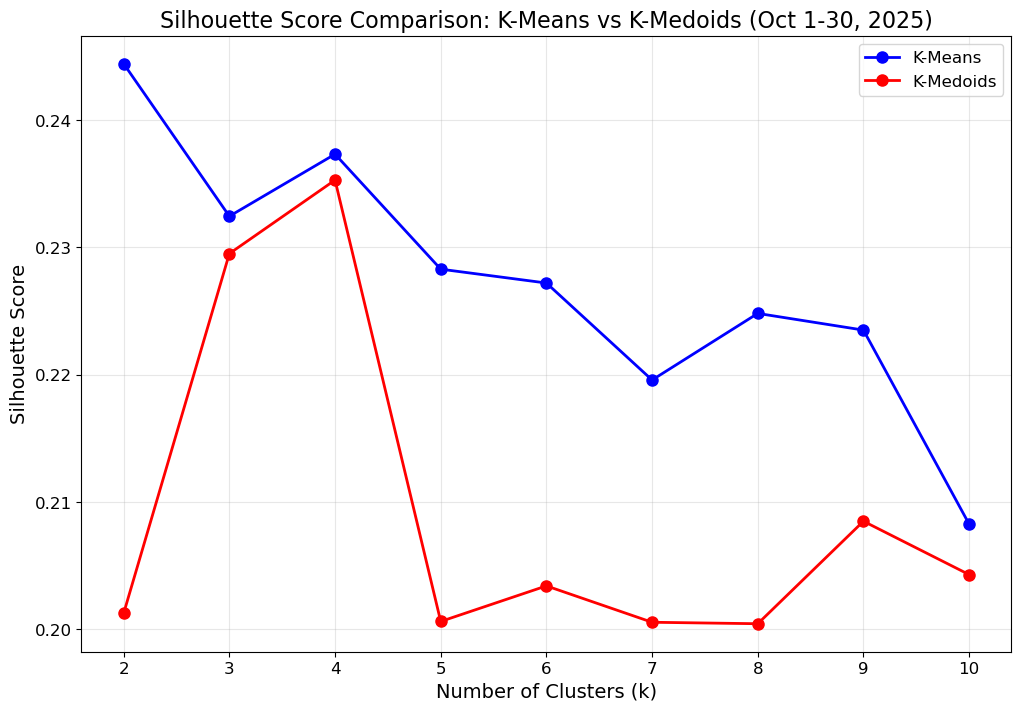

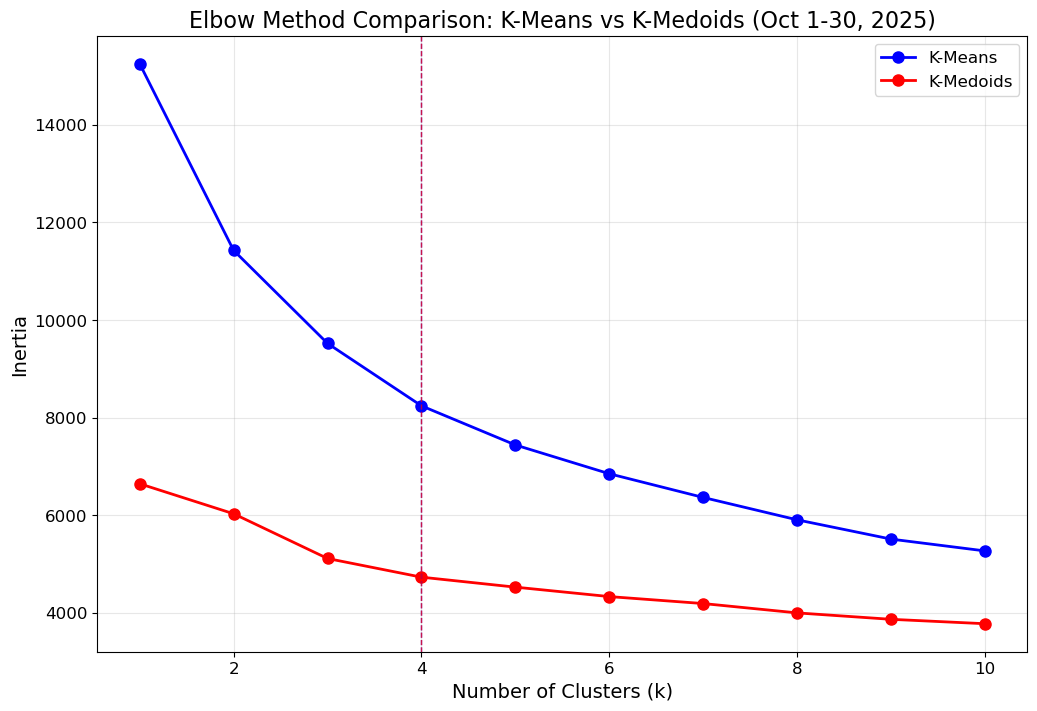


t-SNE VISUALIZATIONS


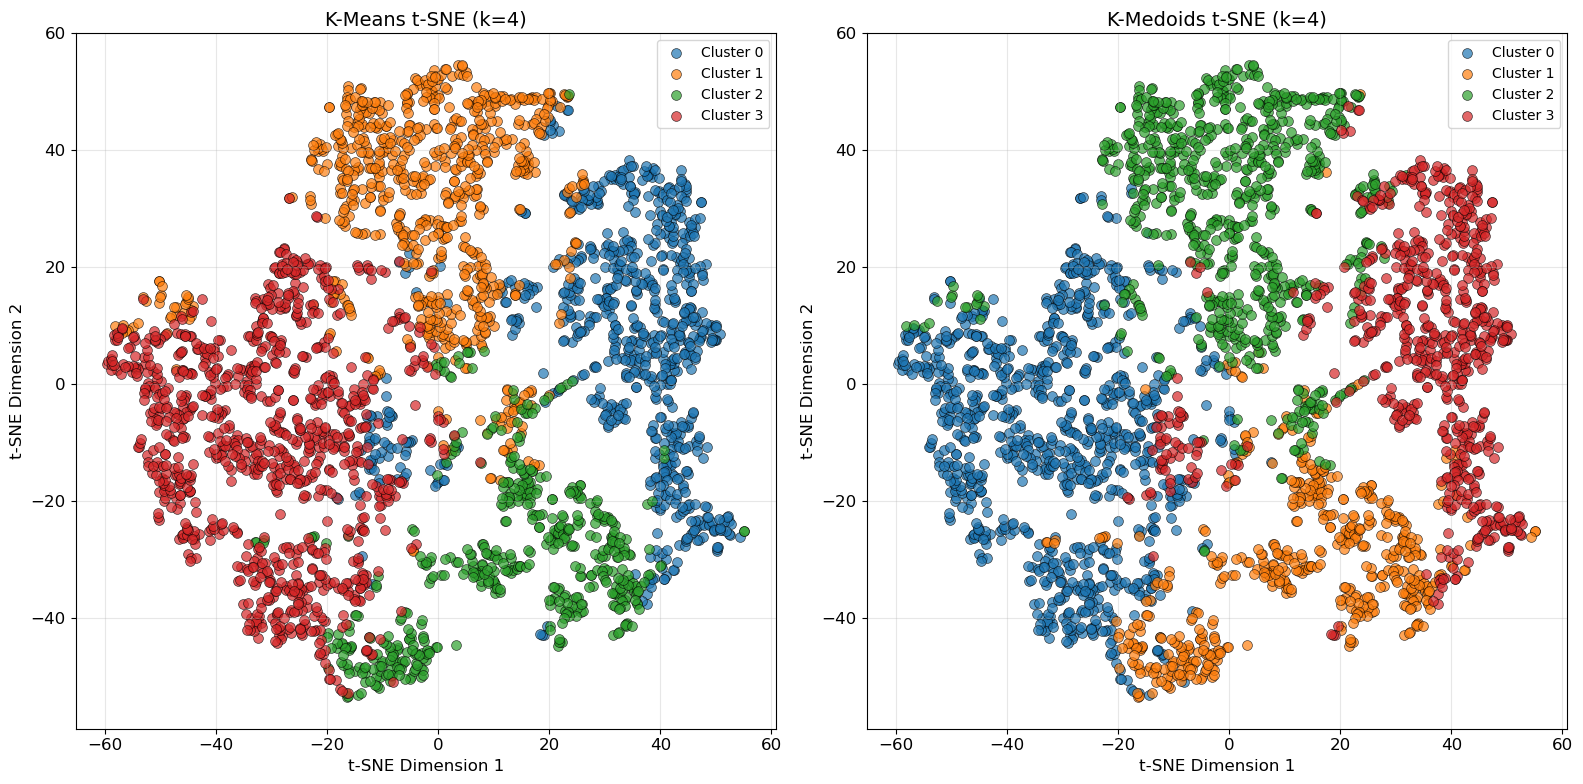

In [23]:
def compare_elbow_curves(self, kmeans_inertia, kmedoids_inertia, optimal_k_kmeans, optimal_k_kmedoids):
    plt.figure(figsize=(12, 8))
    k_range = range(1, 11)
    plt.plot(k_range, kmeans_inertia, 'bo-', linewidth=2, markersize=8, label='K-Means')
    plt.plot(k_range, kmedoids_inertia, 'ro-', linewidth=2, markersize=8, label='K-Medoids')
    
    # Add vertical lines for optimal k values
    plt.axvline(x=optimal_k_kmeans, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axvline(x=optimal_k_kmedoids, color='red', linestyle='--', linewidth=1, alpha=0.7)
    
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.title('Elbow Method Comparison: K-Means vs K-Medoids (Oct 1-30, 2025)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig('elbow.png', dpi=300, bbox_inches='tight')
    plt.show()

def compare_silhouette_scores(self, kmeans_silhouette_scores, kmedoids_silhouette_scores):
    plt.figure(figsize=(12, 8))
    kmeans_k, kmeans_sil = zip(*[(k, sil) for k, sil in kmeans_silhouette_scores if sil is not None])
    kmedoids_k, kmedoids_sil = zip(*[(k, sil) for k, sil in kmedoids_silhouette_scores if sil is not None])
    
    plt.plot(kmeans_k, kmeans_sil, 'bo-', linewidth=2, markersize=8, label='K-Means')
    plt.plot(kmedoids_k, kmedoids_sil, 'ro-', linewidth=2, markersize=8, label='K-Medoids')
    
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.title('Silhouette Score Comparison: K-Means vs K-Medoids (Oct 1-30, 2025)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig('silhouette_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def tsne_visualization(self, kmeans_clusters, kmedoids_clusters, optimal_k_kmeans, optimal_k_kmedoids):
    print("\nt-SNE VISUALIZATIONS")    
    # Create t-SNE object
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    
    # Fit and transform the data for K-Means
    tsne_kmeans = tsne.fit_transform(self.X_scaled)
    
    # Create a DataFrame for easier plotting
    tsne_kmeans_df = pd.DataFrame({
        'tsne_1': tsne_kmeans[:, 0],
        'tsne_2': tsne_kmeans[:, 1],
        'cluster': kmeans_clusters
    })
    
    # Fit and transform the data for K-Medoids
    tsne_kmedoids = tsne.fit_transform(self.X_scaled)
    
    # Create a DataFrame for easier plotting
    tsne_kmedoids_df = pd.DataFrame({
        'tsne_1': tsne_kmedoids[:, 0],
        'tsne_2': tsne_kmedoids[:, 1],
        'cluster': kmedoids_clusters
    })
    
    # Create a figure with subplots for side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Use distinct colors for each cluster
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Plot K-Means t-SNE visualization
    for cluster in range(optimal_k_kmeans):
        cluster_data = tsne_kmeans_df[tsne_kmeans_df['cluster'] == cluster]
        ax1.scatter(cluster_data['tsne_1'], cluster_data['tsne_2'], 
                   label=f'Cluster {cluster}', alpha=0.7, s=50,
                   color=colors[cluster % len(colors)], edgecolors='black', linewidth=0.5)
    
    ax1.set_title(f'K-Means t-SNE (k={optimal_k_kmeans})', fontsize=14)
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot K-Medoids t-SNE visualization
    for cluster in range(optimal_k_kmedoids):
        cluster_data = tsne_kmedoids_df[tsne_kmedoids_df['cluster'] == cluster]
        ax2.scatter(cluster_data['tsne_1'], cluster_data['tsne_2'], 
                   label=f'Cluster {cluster}', alpha=0.7, s=50,
                   color=colors[cluster % len(colors)], edgecolors='black', linewidth=0.5)
    
    ax2.set_title(f'K-Medoids t-SNE (k={optimal_k_kmedoids})', fontsize=14)
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('tsne.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return tsne_kmeans_df, tsne_kmedoids_df

EarthquakeAnalysis.compare_elbow_curves = compare_elbow_curves
EarthquakeAnalysis.compare_silhouette_scores = compare_silhouette_scores
EarthquakeAnalysis.tsne_visualization = tsne_visualization

print("CLUSTERING COMPARISON")
print(f"K-Means:   k={kmeans_results['optimal_k']}, Silhouette Score={kmeans_results['silhouette']:.4f}, Time={kmeans_results['time']:.4f}s")
print(f"K-Medoids: k={kmedoids_results['optimal_k']}, Silhouette Score={kmedoids_results['silhouette']:.4f}, Time={kmedoids_results['time']:.4f}s")

if kmedoids_results['silhouette'] > kmeans_results['silhouette']:
    print("\nK-Medoids provides better clustering for this earthquake data.")
    clusters = kmedoids_results['clusters']
    method = "K-Medoids"
    optimal_k = kmedoids_results['optimal_k']
else:
    print("\nK-Means provides better clustering for this earthquake data.")
    clusters = kmeans_results['clusters']
    method = "K-Means"
    optimal_k = kmeans_results['optimal_k']

# Plot comparison of silhouette scores
analysis.compare_silhouette_scores(
    kmeans_results['silhouette_scores'], kmedoids_results['silhouette_scores'])

# Plot comparison of elbow curves
analysis.compare_elbow_curves(
    kmeans_results['inertia'], kmedoids_results['inertia'],
    kmeans_results['optimal_k'], kmedoids_results['optimal_k'])

# Create t-SNE visualizations
tsne_kmeans_df, tsne_kmedoids_df = analysis.tsne_visualization(
    kmeans_results['clusters'], kmedoids_results['clusters'], 
    kmeans_results['optimal_k'], kmedoids_results['optimal_k'])

## 8. Feature Importance Analysis
We analyze which features contribute most to the clustering based on between-cluster and within-cluster variance.

Feature Importance for Clustering:
Higher importance means the feature better separates the clusters.


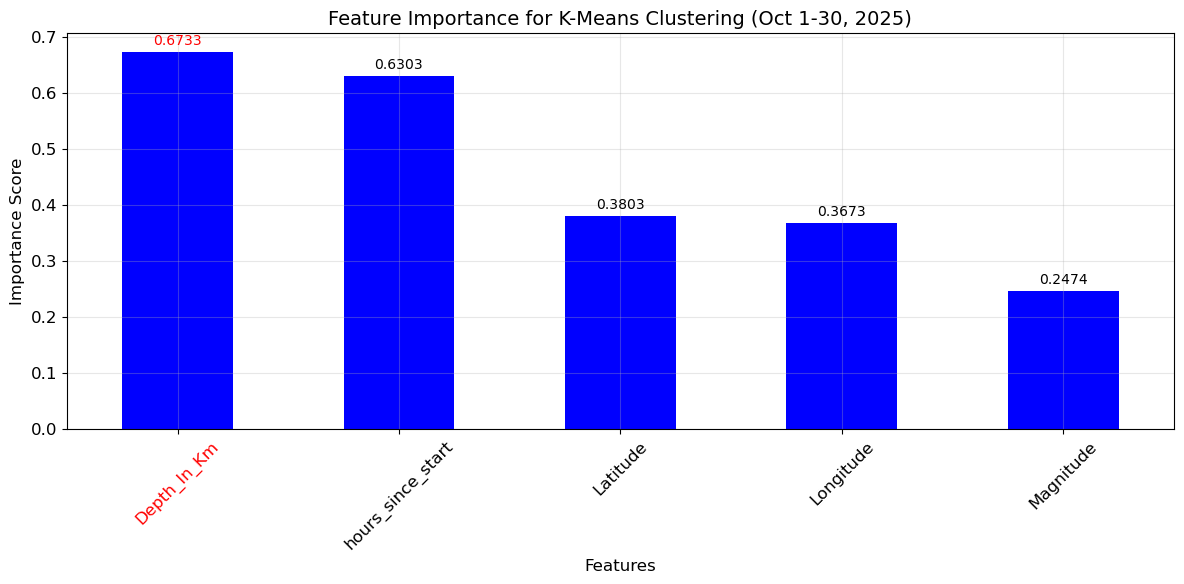

In [24]:
def calculate_feature_importance(self, clusters, optimal_k):
    feature_importance = {}

    for i, feature_name in enumerate(self.features):
        # Get the feature column
        feature_data = self.X_scaled[:, i]

        # Calculate total variance of the feature
        total_variance = np.var(feature_data)

        # Calculate within-cluster variance
        within_cluster_variance = 0
        for cluster_id in range(optimal_k):
            # Get data points for this cluster
            cluster_mask = (clusters == cluster_id)
            cluster_feature_data = feature_data[cluster_mask]

            # Calculate variance for this cluster and weight by cluster size
            if len(cluster_feature_data) > 1:
                cluster_variance = np.var(cluster_feature_data)
                cluster_weight = len(cluster_feature_data) / len(feature_data)
                within_cluster_variance += cluster_variance * cluster_weight

        # Calculate importance score
        importance = (total_variance - within_cluster_variance) / total_variance if total_variance > 0 else 0
        feature_importance[feature_name] = importance

    return feature_importance

def plot_feature_importance(self, feature_importance, method):
    print("Feature Importance for Clustering:")
    print("Higher importance means the feature better separates the clusters.")
    plt.figure(figsize=(12, 6))
    
    # Convert to pandas Series for plotting
    feature_importance_series = pd.Series(feature_importance).sort_values(ascending=False)
    ax = feature_importance_series.plot(kind='bar', color='blue')
    plt.title(f'Feature Importance for {method} Clustering (Oct 1-30, 2025)', fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', alpha=0.3)

    # Add exact importance scores as text labels on top of each bar
    for i, (feature, importance) in enumerate(feature_importance_series.items()):
        # Get the bar properties
        bar = ax.patches[i]
        # Get the x and y positions for the text
        x_pos = i
        y_pos = importance + 0.01 * ax.get_ylim()[1]  # Small vertical offset

        # Set text color: red for the highest importance, black for others
        text_color = 'red' if i == 0 else 'black'

        # Add the text label
        ax.text(x_pos, y_pos, f'{importance:.4f}',
                ha='center', va='bottom', fontsize=10, color=text_color)

    # Get the current x-tick labels
    xtick_labels = [item.get_text() for item in ax.get_xticklabels()]

    # Set the color of the first label (highest importance) to red
    xtick_colors = ['red' if i == 0 else 'black' for i in range(len(xtick_labels))]

    # Apply the colors to the x-tick labels
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_color(xtick_colors[i])

    plt.tight_layout()
    plt.savefig('feature-importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Add methods to class
EarthquakeAnalysis.calculate_feature_importance = calculate_feature_importance
EarthquakeAnalysis.plot_feature_importance = plot_feature_importance

# Calculate and plot feature importance
feature_importance = analysis.calculate_feature_importance(clusters, optimal_k)
analysis.plot_feature_importance(feature_importance, method)

## 9. Cluster Characteristics Analysis
We analyze the characteristics of each cluster in detail, including spatial distribution, temporal patterns, and seismic properties.

Cluster 0:
  Number of earthquakes: 772 (25.3% of total)
  Significant earthquakes (M≥3.5): 103
  Largest earthquake: 2025-10-13 01:06:00, M 5.8
  Time span: 2025-10-01 00:01:00 to 2025-10-29 22:12:00 (28 days)

Cluster 1:
  Number of earthquakes: 756 (24.8% of total)
  Significant earthquakes (M≥3.5): 30
  Largest earthquake: 2025-10-03 05:39:00, M 5.1
  Time span: 2025-10-01 00:12:00 to 2025-10-25 01:55:00 (24 days)

Cluster 2:
  Number of earthquakes: 524 (17.2% of total)
  Significant earthquakes (M≥3.5): 11
  Largest earthquake: 2025-10-24 21:59:00, M 4.6
  Time span: 2025-10-13 15:25:00 to 2025-10-30 23:04:00 (17 days)

Cluster 3:
  Number of earthquakes: 998 (32.7% of total)
  Significant earthquakes (M≥3.5): 2
  Largest earthquake: 2025-10-13 01:31:00, M 3.9
  Time span: 2025-10-01 00:21:00 to 2025-10-28 03:52:00 (27 days)

Cluster Characteristics Summary:


,Cluster ID,"Spatial Center (Lat, Lon)",Spatial Spread (km),Magnitude Range,Depth Range (km)
0,0,"10.961° N, 123.932° E",8.869666,1.3-5.8,1.0-33.0
1,1,"11.133° N, 124.087° E",10.089472,1.2-5.1,1.0-28.0
2,2,"11.069° N, 124.004° E",12.635912,1.2-4.6,1.0-42.0
3,3,"11.093° N, 124.037° E",10.775201,1.0-3.9,8.0-60.0



Displaying earthquake clusters on the map using K-Means with k=4 clusters...



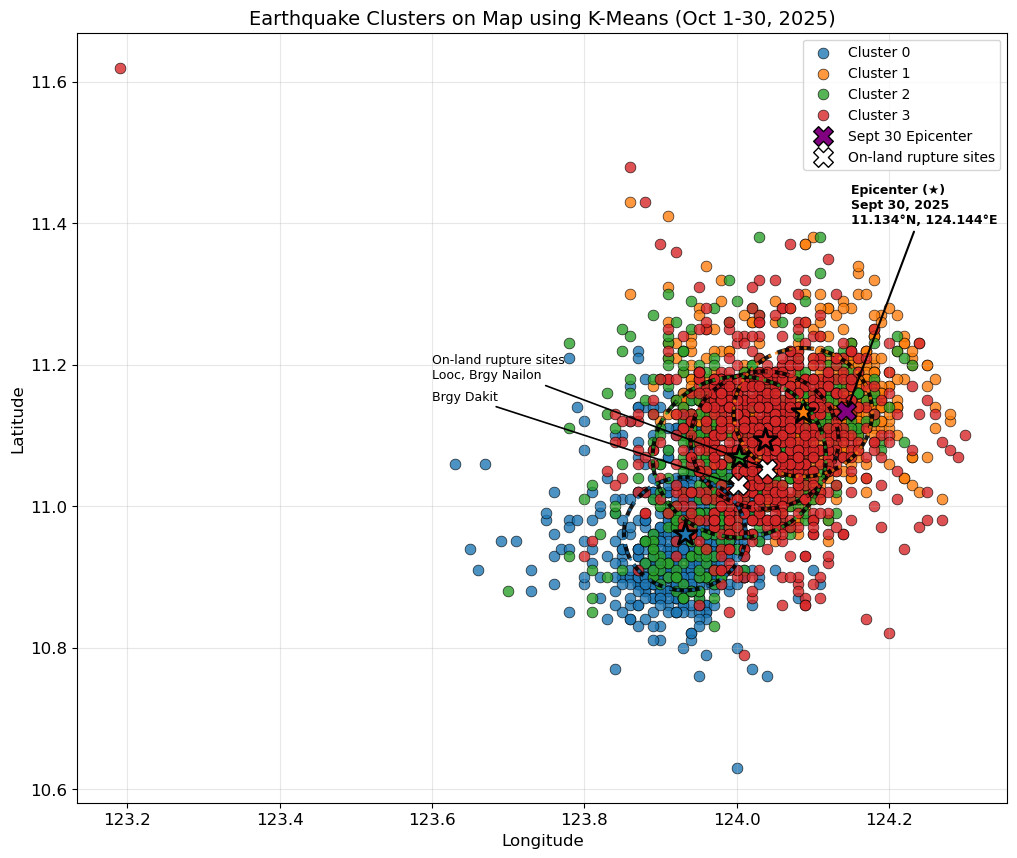

In [63]:
def calculate_spatial_spread(self, cluster_df):
    if len(cluster_df) <= 1:
        return 0.0

    # Calculate the center of the cluster
    center_lat = cluster_df['Latitude'].mean()
    center_lon = cluster_df['Longitude'].mean()

    # Calculate distances from the center using haversine formula
    distances = []
    for _, row in cluster_df.iterrows():
        # Convert to radians
        lat1, lon1 = np.radians(center_lat), np.radians(center_lon)
        lat2, lon2 = np.radians(row['Latitude']), np.radians(row['Longitude'])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        distance = 6371 * c  # Earth radius in km
        distances.append(distance)

    return np.mean(distances)

def format_coordinates(self, lat, lon):
    lat_dir = 'N' if lat >= 0 else 'S'
    lon_dir = 'E' if lon >= 0 else 'W'
    return f"{abs(lat):.3f}° {lat_dir}, {abs(lon):.3f}° {lon_dir}"

def analyze_clusters(self, clusters, optimal_k):
    # Add cluster information to the dataframe
    self.df['cluster'] = clusters
    
    # Calculate total earthquakes for percentage calculation
    total_earthquakes = len(self.df)

    # Create a list to store cluster results
    cluster_results = []

    for cluster in range(optimal_k):
        cluster_df = self.df[self.df['cluster'] == cluster]

        # Calculate statistics
        time_start = cluster_df['datetime'].min()
        time_end = cluster_df['datetime'].max()
        time_span_days = (time_end - time_start).days

        magnitude_min = cluster_df['Magnitude'].min()
        magnitude_max = cluster_df['Magnitude'].max()

        depth_min = cluster_df['Depth_In_Km'].min()
        depth_max = cluster_df['Depth_In_Km'].max()

        lat_mean = cluster_df['Latitude'].mean()
        lon_mean = cluster_df['Longitude'].mean()

        spatial_spread = self.calculate_spatial_spread(cluster_df)

        count = len(cluster_df)
        percentage = (count / total_earthquakes) * 100

        # Identify significant earthquakes (M>=3.5)
        significant_earthquakes = cluster_df[cluster_df['Magnitude'] >= 3.5]
        significant_count = len(significant_earthquakes)

        # Find the largest earthquake
        if not cluster_df.empty:
            largest_earthquake = cluster_df.loc[cluster_df['Magnitude'].idxmax()]
            largest_magnitude = largest_earthquake['Magnitude']
            largest_datetime = largest_earthquake['datetime']
        else:
            largest_magnitude = None
            largest_datetime = None

        # Store results
        cluster_results.append({
            'Cluster ID': cluster,
            'Spatial Center (Lat, Lon)': self.format_coordinates(lat_mean, lon_mean),
            'Spatial Spread (km)': spatial_spread,
            'Magnitude Range': f"{magnitude_min:.1f}-{magnitude_max:.1f}",
            'Depth Range (km)': f"{depth_min:.1f}-{depth_max:.1f}"
        })

        # Print cluster characteristics
        print(f"Cluster {cluster}:")
        print(f"  Number of earthquakes: {count} ({percentage:.1f}% of total)")
        print(f"  Significant earthquakes (M≥3.5): {significant_count}")

        if largest_magnitude is not None:
            print(f"  Largest earthquake: {largest_datetime}, M {largest_magnitude}")
        print(f"  Time span: {time_start} to {time_end} ({time_span_days} days)")
        print()

    # Create a DataFrame with the cluster results
    results_df = pd.DataFrame(cluster_results)

    # Display the results table
    print("Cluster Characteristics Summary:")
    display(results_df)
    
    return results_df

def visualize_clusters(self, clusters, method, optimal_k):
    print(f"\nDisplaying earthquake clusters on the map using {method} with k={optimal_k} clusters...\n")
    
    # Get matplotlib's default color cycle
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(12, 10))
    
    # Plot each cluster with its center and spatial spread
    for cluster in range(optimal_k):
        cluster_df = self.df[self.df['cluster'] == cluster]
        
        # Plot the earthquakes in this cluster
        plt.scatter(cluster_df['Longitude'], cluster_df['Latitude'],
                    label=f'Cluster {cluster}', alpha=0.8, s=60, 
                    color=default_colors[cluster % len(default_colors)], edgecolors='black', linewidth=0.5)
        
        # Calculate and plot the center of the cluster
        center_lat = cluster_df['Latitude'].mean()
        center_lon = cluster_df['Longitude'].mean()
        plt.scatter(center_lon, center_lat, marker='*', s=300, 
                    color=default_colors[cluster % len(default_colors)],
                    edgecolor='black', linewidth=2, zorder=10)
        
        # Calculate and plot the spatial spread (radius) of the cluster
        spatial_spread = self.calculate_spatial_spread(cluster_df)
        radius_deg = spatial_spread / 111  # Convert km to degrees approximately
        
        circle = plt.Circle((center_lon, center_lat), radius_deg, fill=False,
                            edgecolor='black', linestyle='--', linewidth=3, alpha=0.9, zorder=15)
        plt.gca().add_patch(circle)
        
        circle_color = plt.Circle((center_lon, center_lat), radius_deg, fill=False,
                                  edgecolor=default_colors[cluster % len(default_colors)], linestyle=':', 
                                  linewidth=2, alpha=0.8, zorder=20)
        plt.gca().add_patch(circle_color)

    # Add epicenter and on-land rupture markers
    epicenter_lat, epicenter_lon = 11.134, 124.144
    looc_lat, looc_lon = 11.0531, 124.0397
    dakit_lat, dakit_lon = 11.0297, 124.0020

    # Epicenter: prominent marker
    plt.scatter(epicenter_lon, epicenter_lat, marker='X', s=200, color='purple',
                edgecolor='black', linewidth=1.0, zorder=25, label='Sept 30 Epicenter')

    # On-land rupture points: X markers
    plt.scatter([looc_lon, dakit_lon], [looc_lat, dakit_lat],
                marker='X', s=200, color='white', edgecolor='black',
                linewidth=1.0, zorder=25, label='On-land rupture sites')

    # Place labels in a less crowded area with arrows pointing to markers
    # Adjust the text positions as needed for your canvas
    # Epicenter annotation
    plt.annotate(
        "Epicenter (★)\nSept 30, 2025\n11.134°N, 124.144°E",
        xy=(epicenter_lon, epicenter_lat),
        xytext=(124.15, 11.4),  # less crowded area
        textcoords='data',
        fontsize=9,
        color='black',
        weight='bold',
        arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
        zorder=30
    )

    # Rupture sites annotation (single label pointing to Looc, second arrow to Dakit)
    plt.annotate(
        "On-land rupture sites\nLooc, Brgy Nailon",
        xy=(looc_lon, looc_lat),
        xytext=(123.6, 11.18),  # less crowded area
        textcoords='data',
        fontsize=9,
        color='black',
        arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
        zorder=30
    )
    # Second arrow to Dakit from the same text position
    plt.annotate(
        "Brgy Dakit",
        xy=(dakit_lon, dakit_lat),
        xytext=(123.6, 11.15),
        textcoords='data',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', color='black', lw=1.2),
        zorder=30
    )

    plt.title(f'Earthquake Clusters on Map using {method} (Oct 1-30, 2025)', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.savefig('earthquake-clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
EarthquakeAnalysis.calculate_spatial_spread = calculate_spatial_spread
EarthquakeAnalysis.format_coordinates = format_coordinates
EarthquakeAnalysis.analyze_clusters = analyze_clusters
EarthquakeAnalysis.visualize_clusters = visualize_clusters
cluster_results = analysis.analyze_clusters(clusters, optimal_k)
analysis.visualize_clusters(clusters, method, optimal_k)

## 10. Train/Test Split
Now we will split the data into training and testing sets (70% train, 30% test) for our classification models. This allows us to train supervised models to learn the patterns of these clusters and evaluate their performance on unseen data.

In [26]:
def create_train_test_sets(self, clusters):
    # Split the dataframe into training and testing sets (70% train, 30% test)
    # We stratify by the 'cluster' column to ensure the distribution of clusters
    # is the same in both the training and test sets.
    train_df, test_df = train_test_split(
        self.df, 
        test_size=0.3, 
        random_state=42, 
        stratify=self.df['cluster']
    )

    # Save the training set to a CSV file
    train_df.to_csv('earthquake_training_set.csv', index=False)
    print(f"Training set ({len(train_df)} samples) saved to 'earthquake_training_set.csv'")

    # Save the test set to a CSV file
    test_df.to_csv('earthquake_test_set.csv', index=False)
    print(f"Test set ({len(test_df)} samples) saved to 'earthquake_test_set.csv'")
    
    # Prepare data for classifiers
    X_train = train_df[self.features]
    y_train = train_df['cluster'].values
    X_test = test_df[self.features]
    y_test = test_df['cluster'].values

    # Fit the scaler on the training data and transform both sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and print the distribution table
    train_cluster_counts = pd.Series(y_train).value_counts().sort_index()
    test_cluster_counts = pd.Series(y_test).value_counts().sort_index()
    distribution_df = pd.DataFrame({
        'Training Set': train_cluster_counts,
        'Test Set': test_cluster_counts
    }, index=train_cluster_counts.index).fillna(0).astype(int)
    distribution_df.loc['Total'] = distribution_df.sum()
    
    print("\nDistribution of Earthquakes in Training and Test Sets by Cluster:")
    display(distribution_df)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

EarthquakeAnalysis.create_train_test_sets = create_train_test_sets
X_train, X_test, y_train, y_test, scaler = analysis.create_train_test_sets(clusters)

Training set (2135 samples) saved to 'earthquake_training_set.csv'
Test set (915 samples) saved to 'earthquake_test_set.csv'

Distribution of Earthquakes in Training and Test Sets by Cluster:


,Training Set,Test Set
0,540,232
1,529,227
2,367,157
3,699,299
Total,2135,915


## 11. SVC Classifier
Support Vector Machines (SVMs) find optimal hyperplanes to separate classes in high-dimensional spaces. We will use `GridSearchCV` to find the best parameters for our SVC classifier.

SVC CLASSIFIER

Performing GridSearchCV to find the optimal SVC parameters...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best SVC parameters found: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Best SVC cross-validation score: 0.9892

SVC Model Accuracy on Test Set: 0.9913
SVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       232
           1       1.00      0.99      0.99       227
           2       0.97      0.99      0.98       157
           3       1.00      0.99      0.99       299

    accuracy                           0.99       915
   macro avg       0.99      0.99      0.99       915
weighted avg       0.99      0.99      0.99       915


Visualizing SVC predictions in t-SNE space (all features considered)...


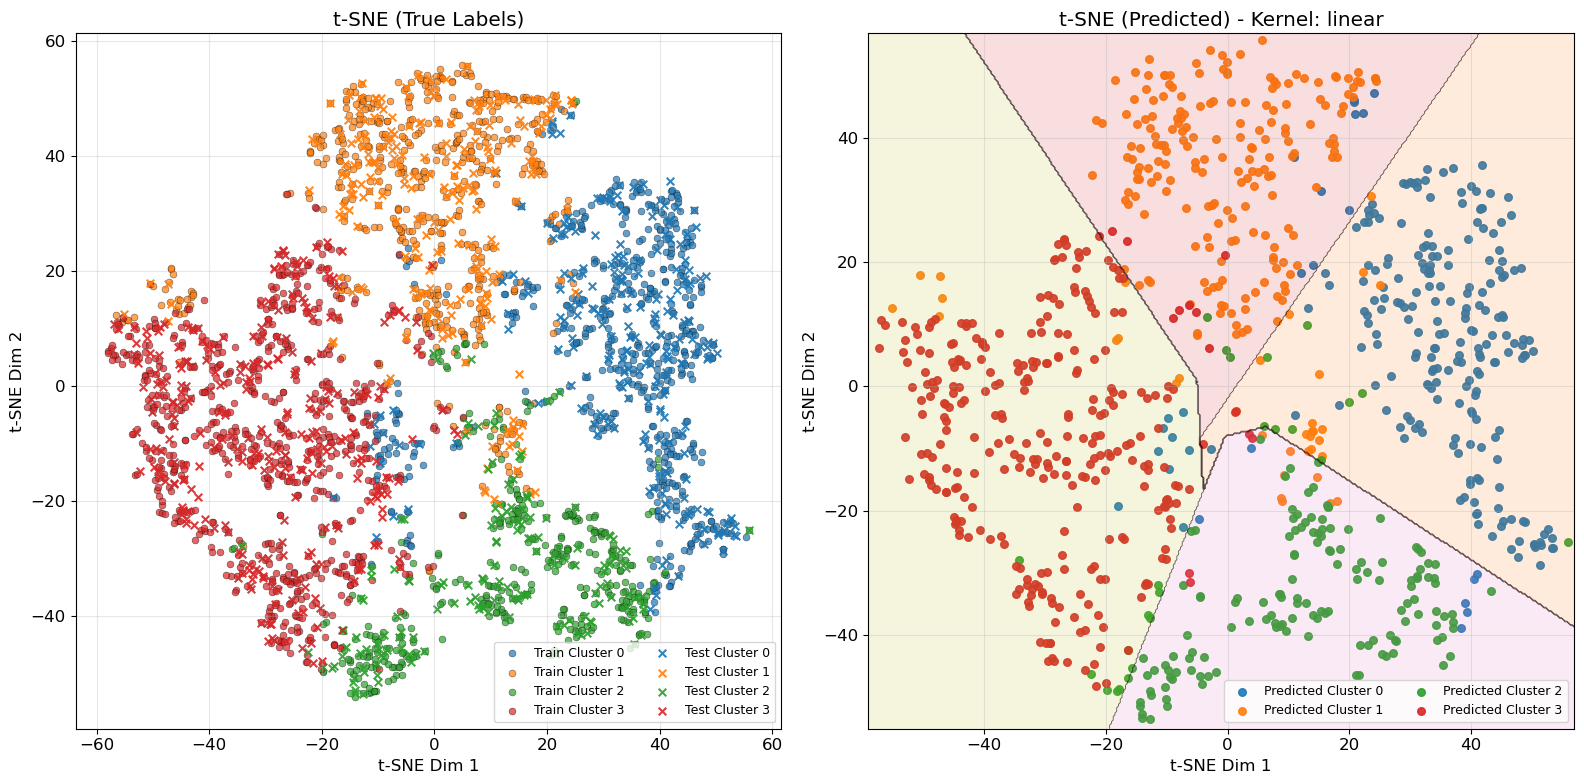

In [41]:
def svc_classifier(self, X_train, X_test, y_train, y_test):
    print("SVC CLASSIFIER")
    print("\nPerforming GridSearchCV to find the optimal SVC parameters...")
    
    # Define the parameter grid to search
    param_grid_svc = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    # Create a GridSearchCV object
    grid_search_svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svc, refit=True, verbose=1, cv=3)
    
    # Fit the grid search to the data
    grid_search_svc.fit(X_train, y_train)
    
    # Print the best parameters and the best score
    print(f"\nBest SVC parameters found: {grid_search_svc.best_params_}")
    print(f"Best SVC cross-validation score: {grid_search_svc.best_score_:.4f}")
    
    # The best estimator is now stored in grid_search_svc.best_estimator_
    best_svc = grid_search_svc.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_svc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nSVC Model Accuracy on Test Set: {accuracy:.4f}")

    print("SVC Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize using TSNE to consider all features
    print("\nVisualizing SVC predictions in t-SNE space (all features considered)...")
    X_all = np.vstack([X_train, X_test])
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_all_tsne = tsne.fit_transform(X_all).astype(np.float32)

    # Split back to train/test embeddings
    n_train = X_train.shape[0]
    X_train_tsne = X_all_tsne[:n_train]
    X_test_tsne = X_all_tsne[n_train:]

    # Colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Left: true labels
    for cls in np.unique(y_train):
        ax1.scatter(X_train_tsne[y_train == cls, 0],
                    X_train_tsne[y_train == cls, 1],
                    label=f'Train Cluster {cls}',
                    s=25, edgecolors='black', linewidth=0.3,
                    alpha=0.7, color=colors[cls % len(colors)])
    for cls in np.unique(y_test):
        ax1.scatter(X_test_tsne[y_test == cls, 0],
                    X_test_tsne[y_test == cls, 1],
                    label=f'Test Cluster {cls}',
                    s=30, marker='x', alpha=0.9, color=colors[cls % len(colors)])
    ax1.set_title('t-SNE (True Labels)')
    ax1.set_xlabel('t-SNE Dim 1')
    ax1.set_ylabel('t-SNE Dim 2')
    ax1.legend(fontsize=9, ncol=2)
    ax1.grid(True, alpha=0.3)

    # Right: predicted labels on test
    for cls in np.unique(y_pred):
        ax2.scatter(X_test_tsne[y_pred == cls, 0],
                    X_test_tsne[y_pred == cls, 1],
                    label=f'Predicted Cluster {cls}',
                    s=30, alpha=0.9, color=colors[cls % len(colors)])
    ax2.set_title(f"t-SNE (Predicted) - Kernel: {grid_search_svc.best_params_['kernel']}")
    ax2.set_xlabel('t-SNE Dim 1')
    ax2.set_ylabel('t-SNE Dim 2')
    ax2.legend(fontsize=9, ncol=2)
    ax2.grid(True, alpha=0.3)

    # Overlay decision boundaries in t-SNE space using the best SVC configuration
    best_params = grid_search_svc.best_params_
    svc_tsne = SVC(
        kernel=best_params.get('kernel', 'rbf'),
        C=best_params.get('C', 1.0),
        gamma=best_params.get('gamma', 'scale'),
        decision_function_shape='ovr',
        random_state=42
    )
    svc_tsne.fit(X_train_tsne, y_train)

    # Create a mesh over the combined t-SNE embedding space
    all_tsne = np.vstack([X_train_tsne, X_test_tsne])
    x_min, x_max = all_tsne[:, 0].min() - 1.0, all_tsne[:, 0].max() + 1.0
    y_min, y_max = all_tsne[:, 1].min() - 1.0, all_tsne[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = svc_tsne.predict(grid).reshape(xx.shape)

    # Plot the decision regions and boundaries
    ax2.contourf(xx, yy, Z, alpha=0.15, levels=np.arange(Z.max()+2)-0.5, cmap=plt.cm.tab10)
    ax2.contour(xx, yy, Z, levels=np.arange(Z.max()+2)-0.5, colors='k', linewidths=0.6, alpha=0.6)

    plt.tight_layout()
    plt.savefig('svc-tsne.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'model': best_svc,
        'accuracy': accuracy,
        'predictions': y_pred,
        'best_params': grid_search_svc.best_params_
    }

EarthquakeAnalysis.svc_classifier = svc_classifier
svc_results = analysis.svc_classifier(X_train, X_test, y_train, y_test)


## 12. XGBoost Classifier
To optimize the XGBoost model, we employed `GridSearchCV` to automatically test different hyperparameters and find the most effective combination. For this multi-classification task, we used the `multi:softprob` objective to have the model output a probability for each cluster. We then evaluated these probabilities using `mlogloss`, or multi-class logarithmic loss, a metric that penalizes the model not only for making incorrect predictions but also for being overconfident in those errors or underconfident in its correct predictions.

In [44]:
def xgb_classifier(self, X_train, X_test, y_train, y_test):
    print("XGBOOST CLASSIFIER")
    print("\nPerforming GridSearchCV to find the optimal XGBoost parameters...")
    
    # Define the parameter grid to search
    param_grid_xgb = {
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Create a GridSearchCV object
    grid_search_xgb = GridSearchCV(
        XGBClassifier(
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            n_jobs=-1
        ),
        param_grid_xgb,
        refit=True,
        verbose=1,
        cv=3,
        scoring='accuracy'
    )
    
    # Fit the grid search to the data
    grid_search_xgb.fit(X_train, y_train)
    
    # Print the best parameters and the best score
    print(f"\nBest XGBoost parameters found: {grid_search_xgb.best_params_}")
    print(f"Best XGBoost cross-validation score: {grid_search_xgb.best_score_:.4f}")
    
    # The best estimator is now stored in grid_search.best_estimator_
    best_xgb = grid_search_xgb.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nXGBoost Model Accuracy on Test Set: {accuracy:.4f}")

    print("XGBoost Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model': best_xgb,
        'accuracy': accuracy,
        'predictions': y_pred,
        'best_params': grid_search_xgb.best_params_
    }

EarthquakeAnalysis.xgb_classifier = xgb_classifier
xgb_results = analysis.xgb_classifier(X_train, X_test, y_train, y_test)

XGBOOST CLASSIFIER

Performing GridSearchCV to find the optimal XGBoost parameters...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best XGBoost parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
Best XGBoost cross-validation score: 0.9564

XGBoost Model Accuracy on Test Set: 0.9596
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       232
           1       0.95      0.95      0.95       227
           2       0.93      0.96      0.95       157
           3       0.97      0.97      0.97       299

    accuracy                           0.96       915
   macro avg       0.96      0.96      0.96       915
weighted avg       0.96      0.96      0.96       915



## 13. Classifier Comparison

Let us compare the performance of both classifiers and visualize the results using confusion matrices. This will help us assess whether the clusters identified by the unsupervised algorithm are meaningful and well-separated.

CLASSIFIER COMPARISON
SVC Accuracy: 0.9913
XGBoost Accuracy: 0.9585

SVC provides better classification for this earthquake data.


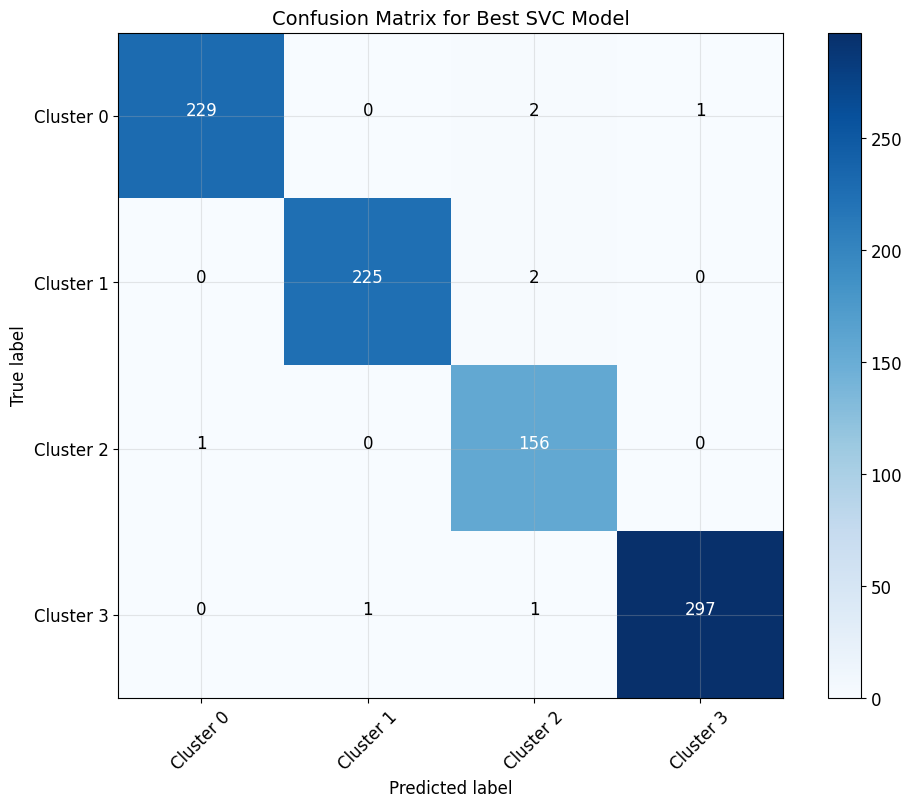

Among 915 earthquake samples in the test set,

Cluster 0:
  - 229 sample(s) correctly identified (True Positive)
  - 3 sample(s) misclassified as other clusters (False Negative)
  - 1 sample(s) from other clusters misidentified as this cluster (False Positive)
  - 682 sample(s) correctly identified as belonging to other clusters (True Negative)
  - Actual count for Cluster 0: 232

Cluster 1:
  - 225 sample(s) correctly identified (True Positive)
  - 2 sample(s) misclassified as other clusters (False Negative)
  - 1 sample(s) from other clusters misidentified as this cluster (False Positive)
  - 687 sample(s) correctly identified as belonging to other clusters (True Negative)
  - Actual count for Cluster 1: 227

Cluster 2:
  - 156 sample(s) correctly identified (True Positive)
  - 1 sample(s) misclassified as other clusters (False Negative)
  - 5 sample(s) from other clusters misidentified as this cluster (False Positive)
  - 753 sample(s) correctly identified as belonging to other clus

In [13]:
def plot_confusion_matrix(self, y_test, y_pred, optimal_k, method):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Best {method} Model', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(optimal_k)
    plt.xticks(tick_marks, [f'Cluster {i}' for i in range(optimal_k)], rotation=45)
    plt.yticks(tick_marks, [f'Cluster {i}' for i in range(optimal_k)])

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.savefig('confusion-matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    total_samples = len(y_test)
    print(f"Among {total_samples} earthquake samples in the test set,\n")

    for i in range(optimal_k):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp
        
        actual_count = np.sum(cm[i, :]) # This is the 'support' for the class

        print(f"Cluster {i}:")
        print(f"  - {tp} sample(s) correctly identified (True Positive)")
        print(f"  - {fn} sample(s) misclassified as other clusters (False Negative)")
        print(f"  - {fp} sample(s) from other clusters misidentified as this cluster (False Positive)")
        print(f"  - {tn} sample(s) correctly identified as belonging to other clusters (True Negative)")
        print(f"  - Actual count for Cluster {i}: {actual_count}\n")

EarthquakeAnalysis.plot_confusion_matrix = plot_confusion_matrix

# Compare classifiers
print("CLASSIFIER COMPARISON")
print(f"SVC Accuracy: {svc_results['accuracy']:.4f}")
print(f"XGBoost Accuracy: {xgb_results['accuracy']:.4f}")

if xgb_results['accuracy'] > svc_results['accuracy']:
    print("\nXGBoost provides better classification for this earthquake data.")
    best_model = xgb_results['model']
    best_method = "XGBoost"
    best_accuracy = xgb_results['accuracy']
    y_pred = xgb_results['predictions']
else:
    print("\nSVC provides better classification for this earthquake data.")
    best_model = svc_results['model']
    best_method = "SVC"
    best_accuracy = svc_results['accuracy']
    y_pred = svc_results['predictions']

# Plot confusion matrix for the best model
analysis.plot_confusion_matrix(y_test, y_pred, optimal_k, best_method)